In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import cm 
from matplotlib.colors import colorConverter, ListedColormap
import seaborn as sns  

# Set seaborn plotting style
sns.set_style('darkgrid')

# Set the seed for reproducibility
np.random.seed(seed=1)

#make dat2
from sklearn.datasets import make_moons

In https://github.com/f3dec/NNFromScratch/blob/main/LogisticRegressionFromScratch.ipynb we built a Logistic Regression from scratch as an example of shallow Neural Network. Let's complicate things a bit and let's add a hidden layer.

## Make data 

Logistic Regression worked well in a case where data was linearly separable but we can see it doesn't work as well when the data is not linearly separable anymore. As an example, let's use again scikit-learn to generate some data.

In [965]:
#make data
X, y = make_moons(100, noise=0.10)
y = y.reshape(y.shape[0],1)
X.shape, y.shape

((100, 2), (100, 1))

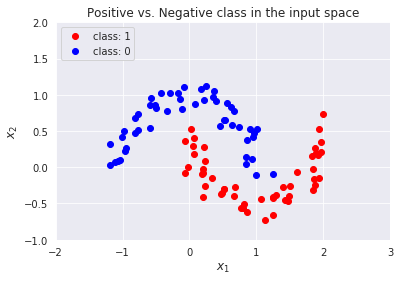

In [966]:
plt.figure(figsize=(6, 4))
plt.plot(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1], 'ro', label='class: 1')
plt.plot(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1], 'bo', label='class: 0')
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-2, 3, -1, 2])
plt.title('Positive vs. Negative class in the input space')
plt.show()

Obviously no straight line will ever perfectly fit the data above and we expect Logistic Regression to perform poorly.

## Logistic Regression

In [1079]:
## Logistic Regression

def cross_entropy(y_hat, y):
    return - np.mean(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

def gradient(y_hat,y,X):
    return np.dot((y_hat - y).T,X)

def sigmoid(z):
    return 1. / (1 + np.exp(-z))

W = np.random.rand(1,X.shape[1]) 

#define parameters for gradient descent
step = 0.05 
n_iter = 15 

losses = []
W_history = np.zeros((n_iter,W.shape[1]))

#iterate
for n in range(n_iter):
    output_layer = np.dot(X,W.T)
    output_activation = sigmoid(output_layer)
    loss = cross_entropy(output_activation, y)
    dW = gradient(output_activation,y,X)
    W -= step * dW
    losses.append(loss)
    W_history[n,:] = W[:]

As we can see from the decision boundary, quite a few points are misclassified bu the model and it's clear we need a model able to come up with non-linear decision boundaries'.

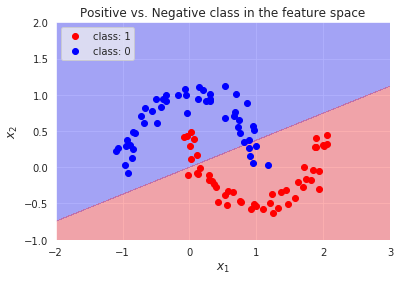

In [1082]:
nb_of_xs = X.shape[0]
xsa = np.linspace(-4, 4, num=nb_of_xs)
xsb = np.linspace(-4, 4, num=nb_of_xs)

xx, yy = np.meshgrid(xsa, xsb)

prediction_matrix = np.zeros((nb_of_xs,nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        prediction_matrix[i,j] = sigmoid(np.dot(np.asmatrix([xx[i,j], yy[i,j]]),W.T))

cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.3),
        colorConverter.to_rgba('r', alpha=0.3)])

plt.figure(figsize=(6, 4))
plt.plot(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1], 'ro', label='class: 1')
plt.plot(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1], 'bo', label='class: 0')
plt.contourf(xx, yy, prediction_matrix, 1, cmap=cmap)
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-2, 3, -1, 2])
plt.title('Positive vs. Negative class in the feature space')
plt.show()

## 1-Layer Neural Network

Let's add one hidden layer to our network. We now have one input layer, one hidden layer and one output layer. We will use the sigmoid as activation function for both the output and hidden layers and cross-entropy as the loss, just like we did for the Logistic Regression. We can then re-use the functions defined above for sigmoid and cross-entropy. 

### Forward Propagation

This step is pretty much the same as in the Logistic Regression example, except that we have two weight matrices - one for the hidden layer and one for the output layer. I have added the dimensions for the weights and each layer for the particular example as I think helps when working out what they should be.

In [ ]:
# initialise parameters for hidden layer
Wh = np.random.rand(len(X[0]),4) # [2,4]

#initialise parameters for output layer
Wo = np.random.rand(4, 1) #[4,1]

In [ ]:
# hidden layer
hidden_layer = np.dot(X,Wh)  #[100,2]x[2,4]=[100,4]
hidden_activation = sigmoid(hidden_layer) #[100,4]

#output layer
output_layer = np.dot(hidden_activation,Wo) #[100,4]x[4,1]=[100,1]
output_activation = sigmoid(output_layer) #[100,1]

### Back Propagation

We can reuse the code from the previous section but with some significant differences in terms of the gradient. The partial derivatives of the loss (cross-entropy) with respect to the weights have different functional forms depending on the layer, so we need to have two different gradient functions. 

The gradient for the output layer is the same as the one we defined for the Logistic Regression (see https://peterroelants.github.io/posts/cross-entropy-logistic/  for the complete dervation). 

In [ ]:
def gradient_output(output_layer,y,X):
    return np.dot((output_layer - y).T,X)

The gradient of cross-entropy with respect to $W_{h}$ can be obtained using the *$\delta$* rule. If *L* is the ouput layer, *$\delta_{L}=\sigma(z)-y$*. It can be demonstrated (see https://rinterested.github.io/statistics/backpropagation.html for derivation) that *$\delta_{L-1}=\delta_{h}=((w_{L-1})^{T}\delta_{L}) \cdot \sigma'(z_{L-1})$*, where $\cdot$ here is element-wise product. The gradient is then $\delta_{L-1}^{T}x$. Note that the $\sigma'(z_{L-1})=\sigma(z_{L-1})*(1-\sigma(z_{L-1}))$ but, by definition, $\sigma(z_{L-1})$ is the hidden layer activation $a_{L-1}$. Consequently $\sigma'(z_{L-1})=a_{L-1}*(1-a_{L-1})$.

In [1088]:
def gradient_hidden(output_layer,y,Wo,hidden_activation,X):
    t = np.dot((output_layer - y),Wo.T)
    sigma_prime = hidden_activation * (1-hidden_activation)
    delta_h = t * sigma_prime
    return np.dot(X.T,delta_h)

We can now implement the gradient as usual. The only difference is that we have to update both the output and the hidden layer weights. Let's put everything together.

In [1094]:
#set seed
np.random.seed(2)

def sigmoid(z):
    return 1. / (1 + np.exp(-z))

def gradient_output(output_layer,y,X):
    return np.dot((output_layer - y).T,X)

def gradient_hidden(output_layer,y,Wo,hidden_activation,X):
    t = np.dot((output_layer - y),Wo.T)
    sigma_prime = hidden_activation * (1-hidden_activation)
    delta_h = t * sigma_prime
    return np.dot(X.T,delta_h)

def cross_entropy(output_layer, y):
    return - np.mean(y * np.log(output_layer) + (1-y) * np.log(1-output_layer))

# initialise parameters for hidden layer
Wh = np.random.rand(len(X[0]),4) # [2,4]

#initialise parameters for output layer
Wo = np.random.rand(4, 1) #[4,1]

#define parameters for gradient descent
step = 0.1
n_iter = 1000

losses = []

for n in range(n_iter):
    
    #forward propagation
    # hidden layer
    hidden_layer = np.dot(X,Wh)  #[100,2]x[2,4]=[100,4]
    hidden_activation = sigmoid(hidden_layer) #[100,4]

    #output layer
    output_layer = np.dot(hidden_activation,Wo) #[100,4]x[4,1]=[100,1]
    output_activation = sigmoid(output_layer) #[100,1]

    #back propagation
    
    #output layer
    output_layer_loss = cross_entropy(output_activation, y) #scalar
    dWo = gradient_output(output_activation,y,hidden_activation).T #[4,1]
    
    #hidden layer
    dWh = gradient_hidden(output_activation,y,Wo,hidden_activation,X) # [2,4]

    #update wights
    Wo -= step * dWo
    Wh -= step * dWh
    losses.append(output_layer_loss)

Let's compare the loss for the two models. The 1-Layer NN achieves a smaller loss tha LR.

In [1103]:
print("Logistic Regression Min Loss: %.2f" % loss)
print("1-Layer NN Min Loss: %.2f" % output_layer_loss)

Logistic Regression Min Loss: 0.28
1-Layer NN Min Loss: 0.18


### Visualize the result

We need to define a prediction function for our model in order to use it later on. 

In [1098]:
def predict(Wh,Wo,X):
    lh = np.dot(X,Wh)
    ah = sigmoid(lh)
    lo = np.dot(ah,Wo)
    ao = sigmoid(lo)
    return ao

Let's look at the decision boundary again. Our 1-Layer classifier performs a lot better than the Logistic Regression. The non-linear decision boundary is able to calssify correctly all red points. There still are some mislassified blue points but overall the classifier does a good job in separating the two classes.

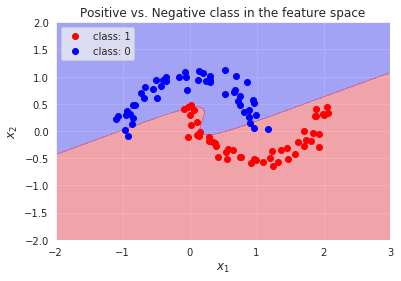

In [1099]:
nb_of_xs = X.shape[0]
xsa = np.linspace(-4, 4, num=nb_of_xs)
xsb = np.linspace(-4, 4, num=nb_of_xs)

xx, yy = np.meshgrid(xsa, xsb)

prediction_matrix = np.zeros((nb_of_xs,nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        prediction_matrix[i,j] = predict(Wh,Wo,np.asmatrix([xx[i,j], yy[i,j]]))

cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.3),
        colorConverter.to_rgba('r', alpha=0.3)])

plt.figure(figsize=(6, 4))
plt.plot(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1], 'ro', label='class: 1')
plt.plot(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1], 'bo', label='class: 0')
plt.contourf(xx, yy, prediction_matrix, 1, cmap=cmap)
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-2, 3, -2, 2])
plt.title('Positive vs. Negative class in the feature space')
plt.show()

Inspiration for the pictures from https://peterroelants.github.io/posts/neural-network-implementation-part02/